<a href="https://colab.research.google.com/github/alessandro-torre/machine-learning/blob/master/computer_vision/4_ResNet_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torchvision
import torch
import torchvision
print(f"torch {torch.__version__}")
print(f"torchvision {torchvision.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

torch 1.12.1+cu113
torchvision 0.13.1+cu113
device: cuda


# Kaggle Fruits 360 with pre-trained ResNet50 as feature extractor

https://www.kaggle.com/datasets/moltean/fruits

### Get the data

Tutorial: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "fruits-360"
zip_path = data_path / "fruits-360.zip"

data_url = "https://lazyprogrammer.me/course_files/fruits-360.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
  print(f"{image_path} directory exists.\n")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  
  # Download
  with open(zip_path, "wb") as f:
    request = requests.get(data_url)
    print("Downloading data...")
    f.write(request.content)

  # Unzip
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    print("Unzipping data...\n") 
    zip_ref.extractall(data_path)

[dir.as_posix() for dir in image_path.glob("*/")]

data/fruits-360 directory exists.



['data/fruits-360/LICENSE',
 'data/fruits-360/readme.md',
 'data/fruits-360/test-multiple_fruits',
 'data/fruits-360/Training',
 'data/fruits-360/Validation',
 'data/fruits-360/papers']


IMAGE_SHAPE=(100, 100, 3)



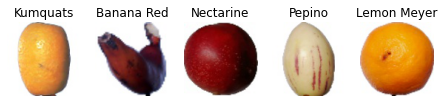

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Setup train and testing paths
train_dir = image_path / "Training"
val_dir = image_path / "Validation"

# Get image size
np.random.seed(42)
train_files = list(train_dir.glob("*/*.jp*g"))
with Image.open(np.random.choice(train_files)) as im:
  IMAGE_SIZE = im.size
  IMAGE_SHAPE = (*IMAGE_SIZE, len(im.getbands()))  # including color channels
print(f"\nIMAGE_SHAPE={IMAGE_SHAPE}\n")

# Show some examples
n = 5
px = 1/plt.rcParams['figure.dpi'] # pixel per inches
random_files = np.random.choice(train_files, n)
fig, ax = plt.subplots(ncols=n, figsize=tuple(1.1*n*x*px for x in IMAGE_SIZE))
for i in range(n):
  with Image.open(random_files[i]) as im:
    ax[i].imshow(np.asarray(im))
    ax[i].set_axis_off()
    ax[i].set_title(random_files[i].parent.stem)
plt.show()

### Load the data

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors. We can use `torchvision.transform` to achieve this, and also to do data augmentation on the train set.

We define a composition of transforms to apply to the data, with `torchvision.transforms.Compose`.

Common transforms for data augmentation are implemented in torchvision. For a list of available transforms, see https://pytorch.org/vision/main/transforms.html.

Examples: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [ ]:
# Write transform for image
data_transform = torchvision.transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.RandomVerticalFlip(),
  torchvision.transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), shear=0.1),  # rotate, translate, shear
  torchvision.transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.66, 1.0)),  # zoom up to 1.5x
  torchvision.transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

Let's write a function to try `data_transform` out on various images.

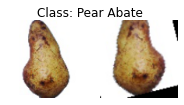

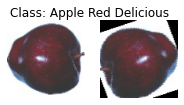

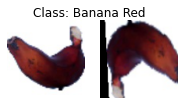

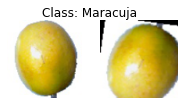

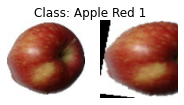

In [ ]:
import random
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
      image_paths (list): List of target image paths. 
      transform (PyTorch Transforms): Transforms to apply to images.
      n (int, optional): Number of images to plot. Defaults to 3.
      seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as im:
      px = 1/plt.rcParams['figure.dpi'] # pixel per inches
      fig, ax = plt.subplots(1,2, figsize=tuple(1.1*px*n*x for n,x in zip((2,1),im.size)))
      ax[0].imshow(im)
      ax[0].set_axis_off()
      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib 
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_im = transform(im).permute(1, 2, 0) 
      ax[1].imshow(transformed_im) 
      ax[1].set_axis_off()
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=12)

plot_transformed_images(train_files, transform=data_transform, n=5)

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder` to turn it into a `Dataset`. Here we also pass the `data_transform` defined previously.

In [ ]:
train_ds = torchvision.datasets.ImageFolder(train_dir, transform = data_transform)
val_ds = torchvision.datasets.ImageFolder(val_dir, transform=data_transform)

# Get set dimensions and number of classes
print(f"N_train={len(train_ds)}, N_val={len(val_ds)}")
class_names = train_ds.classes
#class_dict = train_ds.class_to_idx
K = len(class_names)
print(f"\nNumber of classes: K={K}")

print(f"\nTrain Dataset:\n{train_ds}\n\nValidation Dataset:\n{val_ds}")

N_train=28736, N_val=9673

Number of classes: K=60

Train Dataset:
Dataset ImageFolder
    Number of datapoints: 28736
    Root location: data/fruits-360/Training
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAffine(degrees=[-20.0, 20.0], translate=(0.1, 0.1), shear=[-0.1, 0.1])
               RandomResizedCrop(size=(100, 100), scale=(0.66, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
           )

Validation Dataset:
Dataset ImageFolder
    Number of datapoints: 9673
    Root location: data/fruits-360/Validation
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAffine(degrees=[-20.0, 20.0], translate=(0.1, 0.1), shear=[-0.1, 0.1])
               RandomResizedCrop(size=(100, 100), scale=(0.66, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
              

Turn `Dataset`'s into `DataLoader`'s to make them iterable, to train the model

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()  # how many subprocesses to use for data loading

train_dataloader = torch.utils.data.DataLoader(
  dataset=train_ds, 
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
  pin_memory=True,  # speed up transfering data to gpu during training
  shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
  dataset=val_ds, 
  batch_size=BATCH_SIZE, 
  num_workers=NUM_WORKERS,
  pin_memory=True,
  shuffle=False)  # no need to shuffle validation data

Let's use the dataloaders to plot images from a batch. We can use `torchvision.utils.make_grid` to plot all the images from the batch.

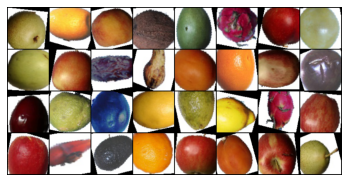

['Pear', 'Kumquats', 'Peach', 'Cocos', 'Mango', 'Pitahaya Red', 'Nectarine', 'Grape White', 'Apple Golden 3', 'Apple Braeburn', 'Dates', 'Pear Abate', 'Apricot', 'Grapefruit Pink', 'Apple Red 3', 'Passion Fruit', 'Cherry', 'Limes', 'Huckleberry', 'Grapefruit White', 'Guava', 'Quince', 'Pitahaya Red', 'Apple Red 1', 'Apple Red Yellow', 'Banana Red', 'Avocado ripe', 'Lemon Meyer', 'Apple Red 2', 'Apricot', 'Apple Braeburn', 'Pear']


In [ ]:
# Get a batch of training data
inputs, targets = next(iter(train_dataloader))

# Make a grid from batch and plot it
inputs_grid = torchvision.utils.make_grid(inputs).permute(1, 2, 0) 
plt.imshow(inputs_grid);
#plt.title([class_names[x] for x in targets])
plt.axis('off');
plt.show()
print([class_names[x] for x in targets])

### Define the model

In [ ]:
# Load resnet50 with pretrained weigths
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

# Freeze the weigths
for param in model.parameters():
  param.requires_grad = False

# Replace the classification layer
in_features = model.fc.in_features  # save in_features before replacing the layer
H = 100  # neuron in the hidden layer
model.fc = torch.nn.Sequential(
  torch.nn.Linear(in_features, H),
  torch.nn.ReLU(inplace=True),
  torch.nn.Linear(H, K)).to(device)

Let's display the model. We could simply use `model.named_modules`, but `torchinfo.summary` provides much more information, including trainable vs non-trainable parameters, and keeping track of shapes.

In [ ]:
!pip install -q torchinfo
import torchinfo
print(f"torchvision {torchvision.__version__}")

# Display the model
#model.named_modules
torchinfo.summary(model, 
  input_size=(1, IMAGE_SHAPE[2], IMAGE_SHAPE[0], IMAGE_SHAPE[1]), # (batch_size, color_channels, height, width)
  verbose=0,
  col_names=["input_size", "output_size", "num_params", "trainable"],
  col_width=20,
  row_settings=["var_names"]
)

torchvision 0.13.1+cu113


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 100, 100]     [1, 60]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 100, 100]     [1, 64, 50, 50]      (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 50, 50]      [1, 64, 50, 50]      (128)                False
├─ReLU (relu)                            [1, 64, 50, 50]      [1, 64, 50, 50]      --                   --
├─MaxPool2d (maxpool)                    [1, 64, 50, 50]      [1, 64, 25, 25]      --                   --
├─Sequential (layer1)                    [1, 64, 25, 25]      [1, 256, 25, 25]     --                   False
│    └─Bottleneck (0)                    [1, 64, 25, 25]      [1, 256, 25, 25]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 25, 25]      [1, 64, 25, 25]      (4,096)              False
│    │    

### `train` helper function

We define helper functions to train the model

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits= model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_logits, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred = y_logits.argmax(dim=1)
      train_acc += (y_pred == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          y_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(y_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          y_pred = y_logits.argmax(dim=1)
          test_acc += ((y_pred == y).sum().item()/len(y_pred))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

### Train and evaluate

In [ ]:
NUM_EPOCHS = 5

# Set the random seeds
torch.manual_seed(666)
torch.cuda.manual_seed(666)

# Set loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train and time it
from timeit import default_timer
start_time = default_timer()

results = train(
  model=model,
  train_dataloader=train_dataloader,
  test_dataloader=val_dataloader,
  loss_fn=loss_fn,
  optimizer=optimizer,
  epochs=NUM_EPOCHS,
  device=device
)

end_time = default_timer()
print(f"Total training time: {end_time-start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7480 | train_acc: 0.8403 | test_loss: 0.2763 | test_acc: 0.9171
Epoch: 2 | train_loss: 0.1743 | train_acc: 0.9527 | test_loss: 0.1646 | test_acc: 0.9485
Epoch: 3 | train_loss: 0.1265 | train_acc: 0.9621 | test_loss: 0.1719 | test_acc: 0.9453
Epoch: 4 | train_loss: 0.1042 | train_acc: 0.9680 | test_loss: 0.1577 | test_acc: 0.9505
Epoch: 5 | train_loss: 0.0936 | train_acc: 0.9690 | test_loss: 0.1441 | test_acc: 0.9531
Total training time: 278.86 seconds


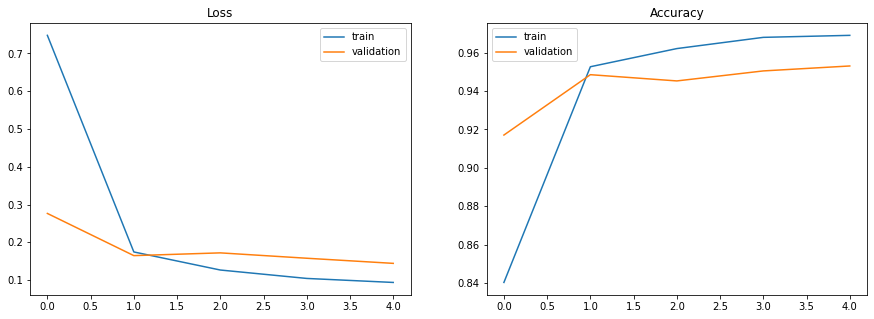

In [ ]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(results["train_loss"], label="train")
ax[0].plot(results["test_loss"], label="validation")
ax[0].set_title("Loss")
ax[0].legend();
ax[1].plot(results["train_acc"], label="train")
ax[1].plot(results["test_acc"], label="validation")
ax[1].set_title("Accuracy")
ax[1].legend();
plt.show()

We now want to display the confusion matrix.

We calculate it with `torchmetrics.classification.MulticlassConfusionMatrix` and we plot it with `mlxtend.plotting.plot_confusion_matrix`.

In [ ]:
# Apply model to the validation set
start_time = default_timer()
model.eval()
with torch.inference_mode():
  for batch, (X, y) in enumerate(val_dataloader):
    X, y = X.to(device), y.to(device)
    p = model(X).argmax(dim=1)
    if not batch:
      predictions, targets = p, y
    else:
      predictions = torch.cat((predictions, p))
      targets = torch.cat((targets, y))
    if not (batch+1) % 50:
      print(f"{len(targets)} images processed")
    if len(targets) == len(val_ds):
      print(f"{len(targets)} images processed (done)")
predictions, targets = predictions.cpu(), targets.cpu()
end_time = default_timer()
print(f"Valuation time: {end_time-start_time:.2f} seconds.")

# Calculate the confusion matrix for the validation set
!pip -q install torchmetrics
import torchmetrics
print(f"\ntorchmetrics {torchmetrics.__version__}")

confmat_fn = torchmetrics.classification.MulticlassConfusionMatrix(K)
confmat = confmat_fn(predictions, targets).numpy()

1600 images processed
3200 images processed
4800 images processed
6400 images processed
8000 images processed
9600 images processed
9673 images processed (done)
Valuation time: 11.17 seconds.

torchmetrics 0.10.2


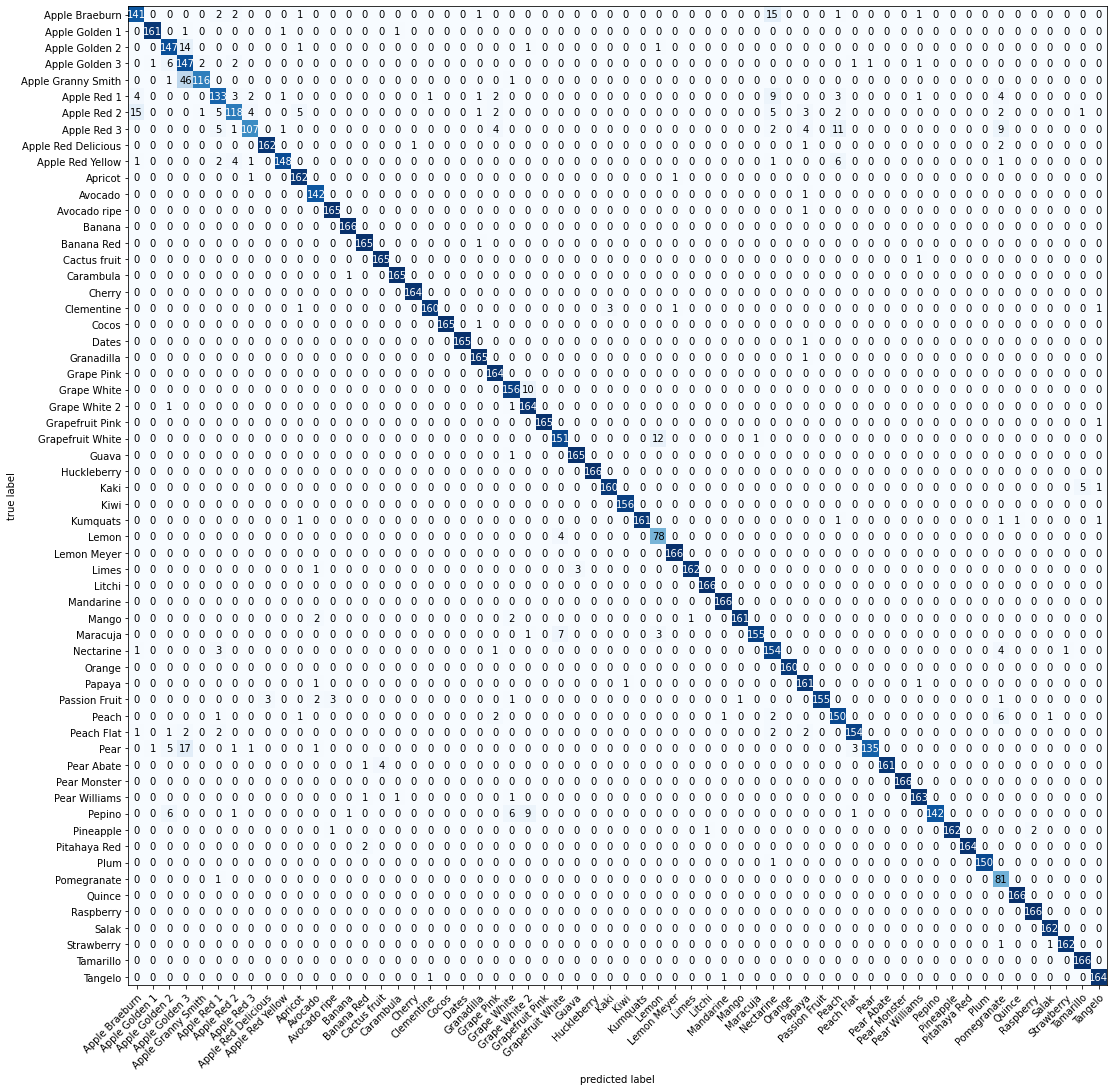

In [ ]:
# Use mlxtend package to plot the confusion matrix
!pip -q install -U mlxtend
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(confmat, class_names=class_names, figsize=(18,18));